# Testing a variant of MNIST after binarizing the pixel values
Lots of us have done classification of the MNIST dataset. Here I do a variation of the MNIST classification by binarizing the pixel value of MNIST. So the pixel value of the image is either 0 or a constant. The model performance is comparable with the original MNIST dataset. Sometimes the model doesn't care about the subtle variations like the specific image pixel value here. 

In [ ]:
# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
# display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
with open('/Users/alexchen/Downloads/mnist/mnist_train.csv','rb') as f:
   data = np.loadtxt(f, delimiter=',', skiprows=1)
# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

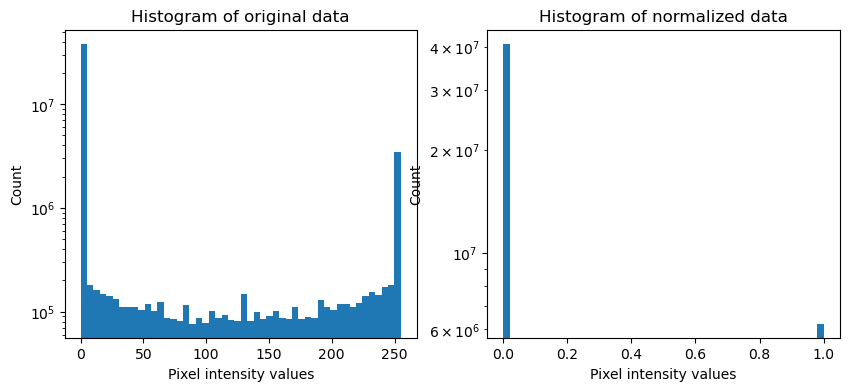

In [10]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)
# binarize the pixel values
dataNorm = np.where(dataNorm < 0.5, 0, 1)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')


plt.show()

# Create train/test groups using DataLoader

In [14]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [16]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [18]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3050, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [19]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [20]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


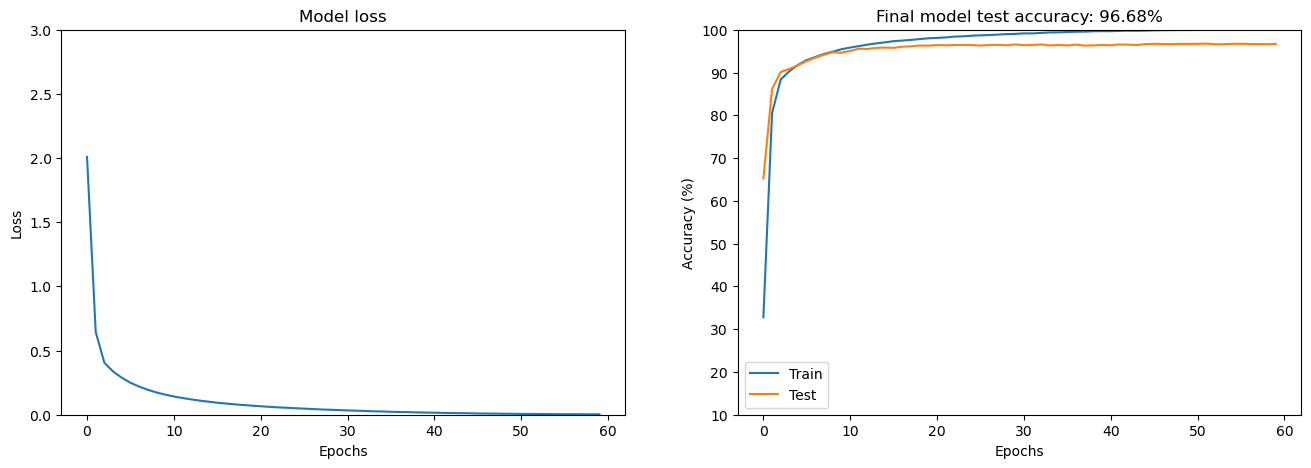

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [22]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[ 0.0000e+00, -5.8489e+01, -1.8134e+01,  ..., -3.7984e+01,
         -3.1472e+01, -2.8680e+01],
        [-3.4633e+01, -1.5973e-04, -1.1871e+01,  ..., -8.7881e+00,
         -1.6315e+01, -2.1117e+01],
        [-3.4885e+01, -2.2743e+01,  0.0000e+00,  ..., -1.7821e+01,
         -3.0778e+01, -4.9998e+01],
        ...,
        [ 0.0000e+00, -6.8114e+01, -2.5413e+01,  ..., -4.2422e+01,
         -2.9700e+01, -3.0440e+01],
        [-3.9904e+01, -4.8073e+01, -4.9316e+01,  ..., -3.0396e+01,
         -3.3341e+01, -2.2191e+01],
        [-3.0036e+01, -4.0422e+01, -3.0409e+01,  ..., -4.4865e+01,
          0.0000e+00, -3.2618e+01]])

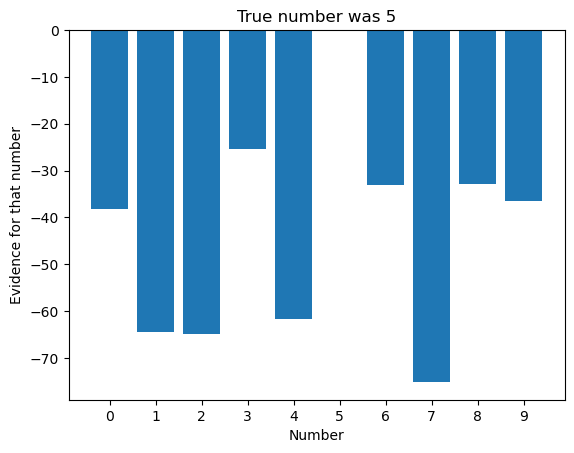

In [23]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  23   38  154  207  214  222  232  254  293  339  370  406  412  417
  428  441  457  492  546  548  622  631  705  760  769  770  809  844
  889  962  964  965  981 1034 1039 1084 1152 1170 1298 1319 1376 1398
 1410 1433 1442 1453 1515 1540 1624 1628 1629 1655 1668 1707 1731 1757
 1815 1845 1859 2018 2022 2023 2049 2112 2167 2184 2226 2229 2255 2294
 2303 2319 2346 2372 2464 2534 2610 2621 2648 2669 2696 2703 2771 2789
 2836 2842 2882 2932 2985 3002 3010 3048 3189 3195 3198 3212 3287 3292
 3330 3343 3345 3359 3397 3538 3558 3561 3583 3620 3636 3644 3654 3699
 3701 3717 3754 3773 3774 3856 3896 3909 3922 3930 3936 3947 3952 3979
 4016 4053 4070 4077 4089 4107 4122 4157 4166 4233 4255 4271 4286 4301
 4346 4378 4413 4448 4459 4462 4468 4479 4486 4506 4510 4512 4527 4552
 4596 4609 4617 4658 4690 4705 4719 4734 4816 4820 4875 4877 4911 4961
 4966 5038 5042 5058 5068 5094 5115 5162 5176 5179 5200 5317 5323 5378
 5430 5441 5470 5484 5509 5514 5534 5548 5572 5704 5769 5820 5851 5866
 5883 

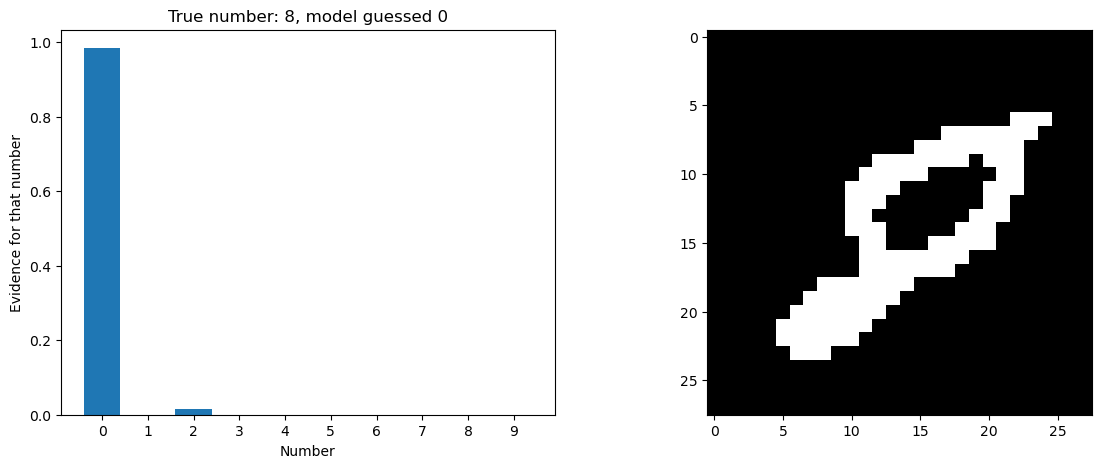

In [24]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()